In [1]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from gensim.models import word2vec
import xgboost as xgb
import matplotlib.pyplot as plt

# from keras.models import Sequential
# from keras.utils.np_utils import to_categorical
# from keras.layers import Dropout, Dense, Activation
# from keras.layers import BatchNormalization

from utils import preprocess
np.random.seed(1234)

In [2]:
num_split = 5

In [3]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [4]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/model.vec')

In [5]:
vec.most_similar(positive=['love'])

[('loved', 0.8400787115097046),
 ('lovelier', 0.8375217914581299),
 ('lover', 0.8341007828712463),
 ('loves', 0.8205721378326416),
 ('clove', 0.8196173906326294),
 ('loveliest', 0.8140965700149536),
 ("beloved's", 0.7933589220046997),
 ("lover's", 0.7773091197013855),
 ('jove', 0.7757792472839355),
 ('glove', 0.7705390453338623)]

In [6]:
vec.most_similar(positive=['the'])

[('theft', 0.8367539048194885),
 ("amalthea's", 0.8247981071472168),
 ('therefrom', 0.8049554824829102),
 ("'υπνος", 0.7993500232696533),
 ('cn', 0.7949093580245972),
 ('xiv', 0.7938920259475708),
 ('oxydracae', 0.786963701248169),
 ('cimabué', 0.7844108939170837),
 ('ottawa', 0.7829217910766602),
 ("azrael's", 0.7828168272972107)]

In [7]:
def create_vector(vec):
    n = vec.vector_size
    x = np.zeros((len(df), n))
    for i, doc in enumerate(df.text):
        doc_vec = np.zeros(n)
        words = preprocess(doc).lower().split()
        num_words = 0
        for w in words:
            if w in vec.vocab:
                doc_vec += vec[w]
                num_words += 1
        doc_vec /= num_words
        x[i] = doc_vec

    x_test = np.zeros((len(df_test), n))
    for i, doc in enumerate(df_test.text):
        doc_vec = np.zeros(n)
        words = preprocess(doc).lower().split()
        num_words = 0
        for w in words:
            if w in vec.vocab:
                doc_vec += vec[w]
                num_words += 1
        doc_vec /= num_words
        x_test[i] = doc_vec
    return x, x_test

In [8]:
def logistic(x, x_test, seed=7):
    num_split = 5
    kf = KFold(n_splits=num_split, random_state=seed, shuffle=True)
    loss = 0.

    predict_prob_features = np.zeros((len(df), 3))
    predict_prob_features_test = np.zeros((len(df_test), 3))

    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = LogisticRegression()
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_val)
        predict_prob_features_test += model.predict_proba(x_test)
        predict_prob_features[val_index] = y_pred
        loss += log_loss(y_pred=y_pred, y_true=y_val)

    print(loss/5)
    return predict_prob_features, predict_prob_features_test

In [9]:
#  ./fasttext skipgram -input ../data/fasttext-inputs.txt -output model -minCount 1  -neg 15 -ws 10 -epoch 7
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/model.vec')
x, x_test = create_vector(vec)

In [10]:
predict_prob_features, predict_prob_features_test = logistic(x, x_test)

0.521292042282


In [11]:
for a, c in author2class.items():
    df['{}_fasttext_logi'.format(a)] = predict_prob_features[:, c]
    df_test['{}_fasttext_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [12]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/skip20_min2_neg15_epoch_7_ws_20.vec') # 0.527408070746
x, x_test = create_vector(vec)
predict_prob_features, predict_prob_features_test = logistic(x, x_test, 7)

0.527408070746


In [13]:
for a, c in author2class.items():
    df['{}_fasttext_low_dim_logi'.format(a)] = predict_prob_features[:, c]
    df_test['{}_fasttext_low_dim_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [14]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/cbow100_min1_neg15_epoch_7_ws_10.vec') # 0.527408070746
x, x_test = create_vector(vec)
predict_prob_features, predict_prob_features_test = logistic(x, x_test, 7)

0.802415782991


In [15]:
for a, c in author2class.items():
    df['{}_fasttext_cbow_logi'.format(a)] = predict_prob_features[:, c]
    df_test['{}_fasttext_cbow_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [16]:
def vectorizer_feature(vectorizer, seed=8):
    kf = KFold(n_splits=num_split, random_state=seed, shuffle=True)
    loss = 0.

    predict_prob_features = np.zeros((len(df), 3))
    predict_prob_features_test = np.zeros((len(df_test), 3))

    for train_index, val_index in kf.split(text):
        print(len(train_index), len(val_index))
        text_train, text_val = text[train_index], text[val_index]
        y_train, y_val = y[train_index], y[val_index]

        x_train = vectorizer.fit_transform(text_train)
        x_val = vectorizer.transform(text_val)

        model = MultinomialNB()
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_val)

        predict_prob_features[val_index] = y_pred
        loss += log_loss(y_pred=y_pred, y_true=y_val)

        predict_prob_features_test += model.predict_proba(vectorizer.transform(text_test))

    print(loss/5)
    return predict_prob_features, predict_prob_features_test


In [17]:
vectorizer = TfidfVectorizer(ngram_range=(4, 5), analyzer='char')

In [18]:
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 8)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
0.604632133935


In [19]:
for a, c in author2class.items():
    df['{}_char_tfidf_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_char_tfidf_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [20]:
df

,id,text,author,EAP_fasttext_logi,HPL_fasttext_logi,MWS_fasttext_logi,EAP_fasttext_low_dim_logi,HPL_fasttext_low_dim_logi,MWS_fasttext_low_dim_logi,EAP_fasttext_cbow_logi,HPL_fasttext_cbow_logi,MWS_fasttext_cbow_logi,EAP_char_tfidf_NB,HPL_char_tfidf_NB,MWS_char_tfidf_NB
0,id26305,"This process, however, afforded me no means of...",EAP,0.837305,0.051619,0.111076,0.835738,0.034526,0.129736,0.504229,0.109957,0.385814,0.980576,0.004380,0.015044
1,id17569,It never once occurred to me that the fumbling...,HPL,0.649287,0.321049,0.029665,0.552652,0.436987,0.010362,0.603734,0.280131,0.116135,0.649059,0.207123,0.143817
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0.765849,0.222766,0.011385,0.822583,0.156184,0.021234,0.496620,0.433573,0.069808,0.915714,0.068426,0.015860
3,id27763,How lovely is spring As we looked from Windsor...,MWS,0.005133,0.043287,0.951579,0.007191,0.028052,0.964757,0.093983,0.507952,0.398065,0.050294,0.033512,0.916194
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,0.324171,0.634930,0.040899,0.503552,0.462670,0.033777,0.403978,0.455321,0.140701,0.843518,0.071520,0.084962
5,id22965,"A youth passed in solitude, my best years spen...",MWS,0.207772,0.059838,0.732390,0.249414,0.022432,0.728154,0.288099,0.120837,0.591064,0.630982,0.004205,0.364813
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,0.947261,0.039617,0.013122,0.917212,0.063144,0.019644,0.794703,0.097394,0.107903,0.925373,0.047962,0.026665
7,id13515,The surcingle hung in ribands from my body.,EAP,0.928303,0.045297,0.026399,0.886854,0.058119,0.055027,0.616012,0.207739,0.176248,0.724636,0.135247,0.140117
8,id19322,I knew that you could not say to yourself 'ste...,EAP,0.587181,0.235327,0.177493,0.640846,0.150306,0.208847,0.325344,0.257696,0.416959,0.916339,0.016015,0.067647
9,id00912,I confess that neither the structure of langua...,MWS,0.255261,0.274112,0.470627,0.122887,0.509650,0.367463,0.469599,0.097470,0.432932,0.584706,0.049637,0.365657


In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word')
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 7)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
0.706003820852


In [22]:
for a, c in author2class.items():
    df['{}_word_tfidf_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_word_tfidf_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [23]:
vectorizer = CountVectorizer(ngram_range=(1, 4), analyzer='word')
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 7)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
0.868949779387


In [24]:
for a, c in author2class.items():
    df['{}_word_count_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_word_count_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [25]:
vectorizer = CountVectorizer(ngram_range=(2, 4), analyzer='char')
predict_prob_features, predict_prob_features_test = vectorizer_feature(vectorizer, 5)

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915
2.50491390234


In [26]:
for a, c in author2class.items():
    df['{}_char_count_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_char_count_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [27]:
# counter = {name : defaultdict(int) for name in set(df.author)}
# for (text, author) in zip(df.text, df.author):
#     text = text.replace(' ', '')
#     for c in text:
#         counter[author][c] += 1
    
# chars = set()
# for v in counter.values():
#     chars |= v.keys()
    
# names = [author for author in counter.keys()]
# special_latters = set()

# for c in chars:    
#     special_latters.add(c)
# special_latters = special_latters - 

In [28]:
normal_latters = set(string.ascii_uppercase) | set(string.ascii_lowercase) | set(',.:;"\'? ')

In [29]:
df['num_chars'] = np.array([len(t) for t in df.text])
df_test['num_chars'] = np.array([len(t) for t in df_test.text])

df['num_words'] = np.array([len(t.split()) for t in df.text])
df_test['num_words'] = np.array([len(t.split()) for t in df_test.text])

df['average_num_chars'] = np.array([np.mean([len(word) for word in t.split()]) for t in df.text])
df_test['average_num_chars'] = np.array([np.mean([len(word) for word in t.split()]) for t in df_test.text])

special = ',;' # ',.:;"\'?'
for c in special:
    df['num_'+c] = np.array([t.count(c) for t in df.text])
    df_test['num_'+c] = np.array([t.count(c) for t in df_test.text])


In [30]:
# num_special_chars = []
# for t in df.text:
#     prod = set(t) - normal_latters
#     c = 0
#     for p in prod:
#         c += t.count(p)
    
#     num_special_chars.append(c)

# df['num_special_chars'] = np.array(num_special_chars)

# num_special_chars = []
# for t in df_test.text:
#     prod = set(t) - normal_latters
#     c = 0
#     for p in prod:
#         c += t.count(p)
    
#     num_special_chars.append(c)

# df_test['num_special_chars'] = np.array(num_special_chars)


In [31]:
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

In [32]:
# kf = model_selection.KFold(n_splits=num_split, shuffle=True, random_state=2017)
# xgb_model = xgb.XGBClassifier()

In [33]:
df.keys()

Index(['EAP_fasttext_logi', 'HPL_fasttext_logi', 'MWS_fasttext_logi',
       'EAP_fasttext_low_dim_logi', 'HPL_fasttext_low_dim_logi',
       'MWS_fasttext_low_dim_logi', 'EAP_fasttext_cbow_logi',
       'HPL_fasttext_cbow_logi', 'MWS_fasttext_cbow_logi', 'EAP_char_tfidf_NB',
       'HPL_char_tfidf_NB', 'MWS_char_tfidf_NB', 'EAP_word_tfidf_NB',
       'HPL_word_tfidf_NB', 'MWS_word_tfidf_NB', 'EAP_word_count_NB',
       'HPL_word_count_NB', 'MWS_word_count_NB', 'EAP_char_count_NB',
       'HPL_char_count_NB', 'MWS_char_count_NB', 'num_chars', 'num_words',
       'average_num_chars', 'num_,', 'num_;'],
      dtype='object')

In [34]:
# df.drop('EAP_fasttext_logi', axis=1, inplace=True)
# df.drop('HPL_fasttext_logi', axis=1, inplace=True)
# df.drop('MWS_fasttext_logi', axis=1, inplace=True)


In [35]:
df

,EAP_fasttext_logi,HPL_fasttext_logi,MWS_fasttext_logi,EAP_fasttext_low_dim_logi,HPL_fasttext_low_dim_logi,MWS_fasttext_low_dim_logi,EAP_fasttext_cbow_logi,HPL_fasttext_cbow_logi,MWS_fasttext_cbow_logi,EAP_char_tfidf_NB,...,HPL_word_count_NB,MWS_word_count_NB,EAP_char_count_NB,HPL_char_count_NB,MWS_char_count_NB,num_chars,num_words,average_num_chars,"num_,",num_;
0,0.837305,0.051619,0.111076,0.835738,0.034526,0.129736,0.504229,0.109957,0.385814,0.980576,...,7.162828e-18,5.301313e-16,1.000000e+00,7.686463e-33,1.889632e-19,231,41,4.658537,4,2
1,0.649287,0.321049,0.029665,0.552652,0.436987,0.010362,0.603734,0.280131,0.116135,0.649059,...,1.604740e-04,8.649724e-05,3.251465e-03,9.967416e-01,6.982648e-06,71,14,4.142857,0,0
2,0.765849,0.222766,0.011385,0.822583,0.156184,0.021234,0.496620,0.433573,0.069808,0.915714,...,5.683646e-09,2.668232e-16,1.000000e+00,1.691362e-18,6.543811e-40,200,36,4.583333,4,0
3,0.005133,0.043287,0.951579,0.007191,0.028052,0.964757,0.093983,0.507952,0.398065,0.050294,...,4.192242e-10,1.000000e+00,3.222466e-44,1.236953e-21,1.000000e+00,206,34,5.088235,3,0
4,0.324171,0.634930,0.040899,0.503552,0.462670,0.033777,0.403978,0.455321,0.140701,0.843518,...,2.451883e-04,1.263713e-05,9.999899e-01,1.013585e-05,1.409548e-12,174,27,5.481481,2,1
5,0.207772,0.059838,0.732390,0.249414,0.022432,0.728154,0.288099,0.120837,0.591064,0.630982,...,1.873509e-24,9.756088e-01,5.883606e-19,4.098365e-61,1.000000e+00,468,83,4.650602,4,0
6,0.947261,0.039617,0.013122,0.917212,0.063144,0.019644,0.794703,0.097394,0.107903,0.925373,...,2.372126e-06,4.171416e-06,1.000000e+00,5.149393e-18,5.577033e-35,128,21,5.142857,3,1
7,0.928303,0.045297,0.026399,0.886854,0.058119,0.055027,0.616012,0.207739,0.176248,0.724636,...,9.661281e-04,1.455680e-02,9.284019e-01,7.159798e-02,1.524057e-07,43,8,4.500000,0,0
8,0.587181,0.235327,0.177493,0.640846,0.150306,0.208847,0.325344,0.257696,0.416959,0.916339,...,2.985410e-28,1.684413e-20,1.000000e+00,2.380365e-34,6.278140e-28,488,88,4.556818,7,1
9,0.255261,0.274112,0.470627,0.122887,0.509650,0.367463,0.469599,0.097470,0.432932,0.584706,...,1.496227e-02,4.545979e-01,3.116705e-04,2.431937e-07,9.996881e-01,144,23,5.304348,2,0


In [36]:
df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)

In [37]:
scale_targets = ['num_words', 'num_chars', 'average_num_chars'] + ['num_{}'.format(c) for c in special]

In [38]:
scale_targets

['num_words', 'num_chars', 'average_num_chars', 'num_,', 'num_;']

In [39]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1 #01
param['max_depth'] = 3
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3
param['seed'] = 7
num_rounds = 6000

cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
results = np.zeros((len(df_test), 3))
for train_ids, val_ids in kf.split(df):
    x_train, x_val = df.loc[train_ids], df.loc[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]
    print(len(x_train), len(x_val))
    

    for k in scale_targets:
        scaler = MinMaxScaler()
        x_train[k] = scaler.fit_transform(x_train[k].values.reshape(len(x_train[k]), 1)).reshape(-1)
        x_val[k] = scaler.transform(x_val[k].values.reshape(len(x_val[k]), -1)).reshape(-1)
        df_test[k] = scaler.transform(df_test[k].values.reshape(len(df_test[k]), -1)).reshape(-1)

    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)
    xgtest = xgb.DMatrix(x_val, label=y_val)
    
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=50)
    

    xgtest2 = xgb.DMatrix(df_test)
    results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)


15663 3916
[0]	train-mlogloss:1.0109	test-mlogloss:1.01083
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.


/Users/nzw/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[50]	train-mlogloss:0.345326	test-mlogloss:0.353515
[100]	train-mlogloss:0.309322	test-mlogloss:0.33205
[150]	train-mlogloss:0.289086	test-mlogloss:0.326162
[200]	train-mlogloss:0.273453	test-mlogloss:0.324095
[250]	train-mlogloss:0.259624	test-mlogloss:0.322766
[300]	train-mlogloss:0.247948	test-mlogloss:0.322121
[350]	train-mlogloss:0.237344	test-mlogloss:0.321645
[400]	train-mlogloss:0.227401	test-mlogloss:0.321479
[450]	train-mlogloss:0.217852	test-mlogloss:0.321045
[500]	train-mlogloss:0.209169	test-mlogloss:0.321793
[550]	train-mlogloss:0.201137	test-mlogloss:0.322898
[600]	train-mlogloss:0.193196	test-mlogloss:0.322908
Stopping. Best iteration:
[445]	train-mlogloss:0.218707	test-mlogloss:0.321026

15663 3916
[0]	train-mlogloss:1.01079	test-mlogloss:1.01171
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[50]	train-mlogloss:0.343574	test-mlogloss:0.363479
[100]	train-mlogloss:0

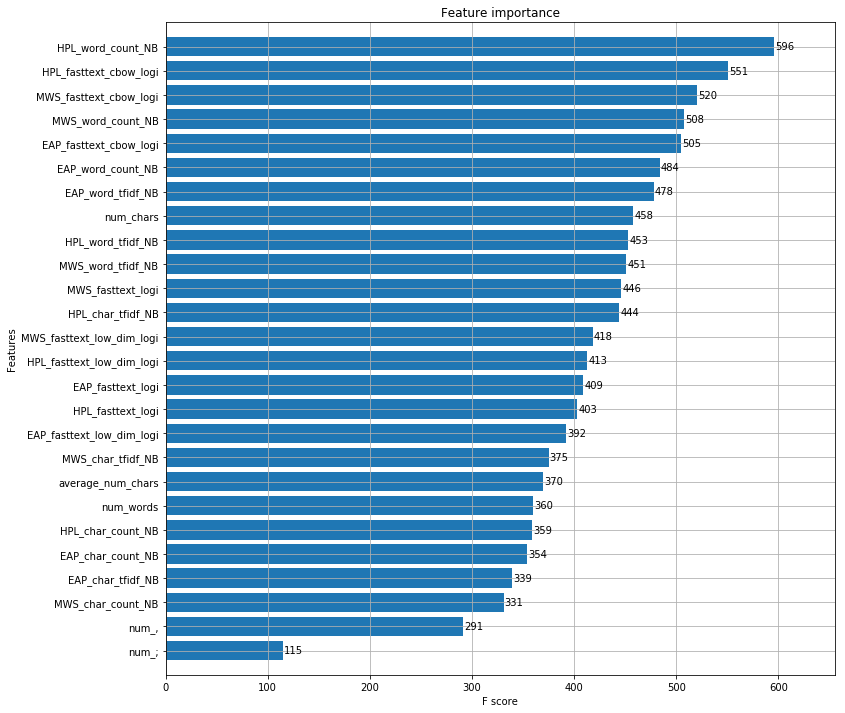

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [41]:
df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    df[a] = results[:, i]/5

with open('./results/first_xgboost.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')